# Mathematical Language Text Understanding with Match-LSTM Network

In this tutorial, we will be using a Match-LSTM model to predict the position of a definiton of a mathematical variable given a variable name and the context in which it is defined.

# The Match-LSTM Model

This model combines multiple attention mechanisms, like Bahdanau-like attention and pointer networks to produce an output. Broadly, the model functions as follows: the model is given a variable name and the context in which it is defined. Then, attention scores for each variable name-context word pair will be computed and processed in an LSTM. The hidden states for this layer are passed to a pointer network that will output the most likely positional of the definition. The following figure shows how each attention layer stacks together to produce the final output.

<div>
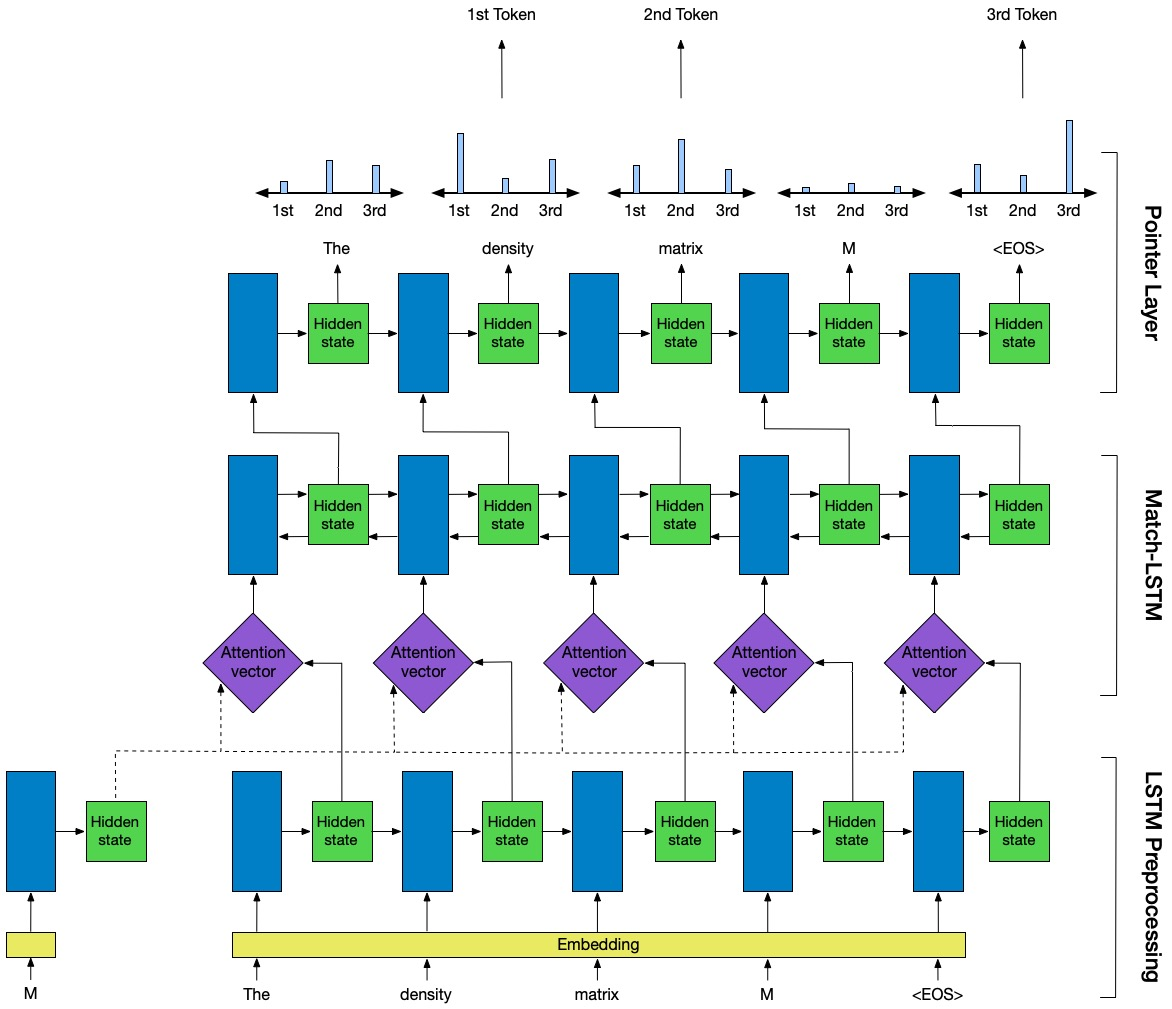
</div>

Let's take a better look at how this model functions. First, the model calulates the hidden states for the context text and the variable name. Then, the attention weights are calculated for every context-variable hidden state pair, which is then feed into a bi-directional LSTM (referred to as a match-LSTM). The attention in the match-LSTM layer is calculated as such:

\begin{align}
G_{i} = tanh(W^{v}h^{v} + (W^{c}h_{i}^{c} + W^{r}h_{i-1}^{r} + b^{c}))
\end{align}
\begin{align}
\alpha_{i} = w^{\top}G_{i} + b
\end{align}

Here, $W^{v}, W^{c}, W^{r}, b^{c}, w, b$ are learned weights, $h_{i}^{c}$ and $h^{v}$ are the hidden states of the $i-th$ word of the context text and the variable name respectively, and $h_{i-1}^{r}$ is the previous hidden state of the match-lstm. The attention weights are then combine with $h_{i}^{c}$ and $h^{v}$ and processed in the match-LSTM. This process is done in the forward and backwards direction and all resulting hidden states are coalesced into a final hidden state vector. The final hidden state vector is processed by a pointer layer. This layer then calculates the most likely position of the definition of variable in the context text. The following formulas show how this is done:

\begin{align}
F_{j} = tanh(V\bar{H^{r}} + (W^{a}h_{k - 1}^{a} + b^{a}) \otimes e_{C + 1})
\end{align}
\begin{align}
\beta_{j} = softmax(v^{\top}F_{j} + b \otimes e_{C + 1}) 
\end{align}

where $V, W^{a}, b^{a}, v$ and $b$ are learned weights, $\bar{H^{r}}$ is the vector of concatenated match-LSTM hidden states, $h_{k - 1}^{a}$ is the previous hidden state of the pointer LSTM and $e_{C + 1}$ is a vector of ones with size C + 1, where C is the length of the context text. $\beta_{j}$ is combined with $h_{j}^{c}$ and processed by an LSTM.

Our model is a slight modification of the model used descibed in this paper: https://arxiv.org/pdf/1608.07905.pdf. We removed the softmax from the attention scores in the Match-LSTM layer as the variable names in our data are always one word.

## Let's get started!
To start, let's define a Pytorch Dataset. This is a data object will take our data and prepare it to be fed into a model. This entails cleaning the data, tokenizing it, and partitioning it into batchs. I highly recommend the use of the pytorch dataset object in any pytorch project you may do because of its compatability with the pytorch dataloader. The dataloader will batch and randomize your data for you, making it easy to train your model.

## The Data and How We Process It
The data used in this tutorial is sourced from mathematical and physics papers from arXiv and manually cleaned. For each entry in the dataset, we are given a variable name, the context in which it is defined, and an definition of the variable. This outputs the most likely position of the definition in the context text, so all output tensors represent the indexes of the definition. 

Our dataset has variable length definitions, so we need a way to adding an \<EOS\> and \<PAD\> token to output tensors. To do this, we add an \<EOS\> and \<PAD\> token to the end of each context so the output can use their positions to generate those tokens. We also pad each output to the maximum output length for ease of training and testing. 

In [1]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import torch
from torch import nn
from torch import optim
import numpy as np
import torch.nn.functional as F
import math

In [2]:
class MatchLSTMDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
        # The tokenized inputs and outputs
        self.vars = []
        self.contexts = []
        self.outputs = []

        # Maps each index to a unique word and vice versa
        self.word2index = {}
        self.index2word = {0: "PAD", 1: "EOS"}
        
        self.pad = 0
        self.eos = 1
        self.size = len(self.index2word)
        self.context_max_len = 0
        self.def_max_len = 0
        
        # Process the data
        self.prep_data()

    def add_text(self, text):
        """Assigns a unique index to each word in a sentence.

        Args:
          text: A sentence
        """
        for word in text.split(' '):
            if word not in self.word2index:
                self.word2index[word] = self.size
                self.index2word[self.size] = word
                self.size += 1

    def clean_text(self, string):
        """Strips text of any punctuation, converts to lower case, and gets rid of any 
        unnecessary white space.

        Args:
          text: the uncleaned sentence.

        Returns:
          The cleaned sentence.
        """
        string = string.replace('"', '').lower().strip()
        string = string.replace(",", "").replace(".", "").replace("!", "").replace("?", "").replace("(", "").replace(")", "").replace(":", "").replace("|", " ").replace("  ", " ").strip().replace(";", "")
        string = string.split(" ")
        string = ' '.join(string)
        return string

    def get_idx(self, context, definition):
        """This function finds positional token of 'definition' in 'context'. 

        Args:
          context: the context in which the variable is defined
          definition: the definition of the variable

        Returns:
          The position of 'definition' in 'context'
        """
        context_split = context.split(" ")
        if definition in context_split:
            # base case, return the idx of the definition in the context
            idx = context_split.index(definition)
        else:
            # This should cover an edge case where the correct definition is the singular version
            # of the definition of the text. It finds the idx of the most similar word to the definition. 
            max_common = 0
            most_likely_idx = 0
            for i in range(len(context_split)):
                word_dist = len(set(definition).intersection(set(context_split[i])))
                if max_common < word_dist:
                    max_common = word_dist
                    most_likely_idx = i
                        
            idx = most_likely_idx
        
        return idx

    def prep_data(self):
        """The main function of the dataset object.
        This function cleans and tokenizes each entry, as well as set the maximum text and definition length. 
        """
        context_max_len = 0
        def_max_len = 0
        for index, row in self.df.iterrows():
            var = self.clean_text(row["var"])
            context = self.clean_text(row["context"])
            definition = self.clean_text(row["def"])

            self.add_text(context)
            
            # Add an EOS and a PAD token so the pointer layer can generate those tokens
            # This way, out pointer layer can handle variable length outputs
            context_text = [self.word2index[c] for c in context.split(" ")] + [self.eos] + [self.pad]
            
            # Output tensors are the positions of the words in the definitions in the context
            output_text = [self.get_idx(context, word) for word in definition.split(" ")]
            
            self.vars.append([self.word2index[var]])
            self.contexts.append(context_text)
            self.outputs.append(output_text)

            if len(context_text) > context_max_len:
                context_max_len = len(context_text)

            if len(output_text) > def_max_len:
                def_max_len = len(output_text)

        # Set the maximum text and definition length
        # This is important when defining the models
        self.context_max_len = context_max_len
        self.def_max_len = def_max_len + 1

    def collate_fn(self, batch):
        """This function is used by the dataloader to create batchs.
        It seperated the inputs and the outputs and then pads them.

        Args:
          batch: A list of data entries of size batch_size.

        Returns:
          The padded inputs and outputs.
        """
        variables = []
        contexts = []
        defs = []
        
        max_output_len = max([len(b[2]) for b in batch])
        
        for b in batch:
            variables.append(torch.LongTensor(b[0]))
            contexts.append(torch.LongTensor(b[1]))
            
            # all outputs are padded to the maximum output length
            output_pad_length = self.def_max_len - len(b[2]) - 1
            
            # each context text has an EOS token and a PAD token at the end
            # The pointer network points to these tokens when generating an EOS or a PAD token
            output_eos = len(b[1]) - 2
            output_pad = len(b[1]) - 1
            defs.append(torch.LongTensor(b[2] + [output_eos] + ([output_pad] * output_pad_length)))

        return (pad_sequence(variables), pad_sequence(contexts), pad_sequence(defs))

    def __len__(self):
        """This is a required function.
        It returns the size of the dataset.

        Returns:
          The size of the dataset.
        """
        return len(self.contexts)

    def __getitem__(self, idx):
        """This is a required function.
        It returns the data entry at index at idx.

        Args:
          idx: An index.

        Returns:
          The data entry at index idx.
        """
        return (self.vars[idx], self.contexts[idx], self.outputs[idx])

## Implementing the Match-LSTM Model

In [3]:
class MatchLSTM(nn.Module):
    """ This class is the second layer of the model. It calculates attention between the 
    variable name and the context tokens using an LSTM. 
    """
    def __init__(self, context_max_len, def_max_len, hidden_size, batch_size, device):
        super().__init__()
        self.context_max_len = context_max_len
        self.def_max_len = def_max_len
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.device = device

        self.context_weights = nn.Linear(hidden_size, hidden_size)
        self.var_weights = nn.Linear(hidden_size, hidden_size, bias=False)
        self.prev_weights = nn.Linear(hidden_size, hidden_size, bias=False)
        self.alpha_weights = nn.Linear(hidden_size, 1, bias=False)
        self.b = nn.Parameter(torch.empty(1))

        self.lstm_match = nn.LSTMCell(2 * hidden_size, hidden_size)

    def forward(self, var_hidden, context_hidden):
        context_size = context_hidden.size(0)

        h_forward = torch.zeros((self.context_max_len, self.batch_size, self.hidden_size), device=self.device)
        h_back = torch.zeros((self.context_max_len, self.batch_size, self.hidden_size), device=self.device)

        h_prev = torch.zeros(self.batch_size, self.hidden_size, device=self.device)
        c = torch.zeros(self.batch_size, self.hidden_size, device=self.device)

        # forward pass
        for i in range(context_size):
            weighted_var = self.var_weights(var_hidden)
            weighted_context = self.context_weights(context_hidden[i]) + self.prev_weights(h_prev) # (batch_size, hidden_size)

            G = torch.tanh(weighted_var + weighted_context)
            
            # use softmax if len(var name) > 1
            a = self.alpha_weights(G) + self.b # (batch_size, 1)
            
            z = torch.cat((context_hidden[i], torch.bmm(var_hidden.unsqueeze(2), a.unsqueeze(1)).squeeze(2)), dim=1) # (batch_size, hidden_size * 2)
            h_prev, c = self.lstm_match(z, (h_prev, c))
            h_forward[i] = h_prev

        h_prev = torch.zeros(batch_size, self.hidden_size, device=self.device)
        c = torch.zeros(batch_size, self.hidden_size, device=self.device)
        
        # backwards pass
        for j in range(context_size):
            idx = context_size - 1 - j
            weighted_var = self.var_weights(var_hidden)
            weighted_context = self.context_weights(context_hidden[idx]) + self.prev_weights(h_prev) # (batch_size, hidden_size)

            G = torch.tanh(weighted_var + weighted_context)
            
            # use softmax if len(var name) > 1
            a = self.alpha_weights(G) + self.b # (batch_size, 1)

            z = torch.cat((context_hidden[idx], torch.bmm(var_hidden.unsqueeze(2), a.unsqueeze(1)).squeeze(2)), dim=1) # (batch_size, hidden_size * 2)
            h_prev, c = self.lstm_match(z, (h_prev, c))
            h_back[idx] = h_prev

        h_forward = h_forward.permute((1, 0, 2)) # (batch_size, context_max_len, hidden_size)
        h_back = h_back.permute((1, 0, 2)) # (batch_size, context_max_len, hidden_size)

        return torch.cat((h_forward, h_back), dim=2) # (batch_size, context_max_len, hidden_size * 2)

class PointerLayer(nn.Module):
    """This class is the last layer of the model. It takes the attention calculated by the
    MatchLSTM layer and decides which tokens in the context are the definition. In this tutorial,
    we used a 'sequence' pointer network as it is better suited for this task then the boundary network. 
    """
    def __init__(self, context_max_len, def_max_len, hidden_size, batch_size, device):
        super().__init__()
        self.context_max_len = context_max_len
        self.def_max_len = def_max_len
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.device = device

        self.context_weights = nn.Linear(2 * hidden_size, hidden_size, bias=False)
        self.prev_weights = nn.Linear(hidden_size, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)
        self.c = nn.Parameter(torch.empty(1))
        self.lstm_cell = nn.LSTMCell(2 * hidden_size, hidden_size)

    def forward(self, H):
        h_prev = torch.zeros(self.batch_size, self.hidden_size, device=self.device)
        c = torch.zeros(self.batch_size, self.hidden_size, device=self.device)

        probs = []
        for i in range(self.def_max_len):
            prev = self.prev_weights(h_prev).unsqueeze(1).repeat(1, self.context_max_len, 1) # (batch_size, context_max_len, hidden size * 2)
            f = torch.tanh(self.context_weights(H) + prev) # (batch_size, context_max_len, hidden size * 2)
            beta = self.v(f) + self.c
            beta = torch.permute(beta, (0, 2, 1))
            beta = F.log_softmax(beta, dim=2) # (batch_size, 1, context_max_len)

            attn_applied = torch.bmm(torch.permute(H, (0, 2, 1)), torch.transpose(beta, dim0=1, dim1=2)).squeeze(-1) # (batch_size, hidden_size * 2)
            h_prev, c = self.lstm_cell(attn_applied, (h_prev, c))
            probs.append(beta.squeeze(1))

        probs = torch.stack(probs, dim=1) # (batch_size, def_max_len, context_max_len)
        return probs

class MatchLSTMModel(nn.Module):
    def __init__(self, learning_rate, context_max_len, def_max_len, size, hidden_size, optimizer, batch_size):
        super().__init__()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.embed = nn.Embedding(size, hidden_size)

        self.context_encoder = nn.LSTM(hidden_size, hidden_size)
        self.def_encoder = nn.LSTM(hidden_size, hidden_size)

        self.match_layer = MatchLSTM(context_max_len, def_max_len, hidden_size, batch_size, device)
        self.pointer_layer = PointerLayer(context_max_len, def_max_len, hidden_size, batch_size, device)
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.context_max_len = context_max_len
        self.def_max_len = def_max_len

        if optimizer == "sgd":
            self.context_opt = optim.SGD(self.context_encoder.parameters(), lr=learning_rate)
            self.var_opt = optim.SGD(self.def_encoder.parameters(), lr=learning_rate)
            self.match_opt = optim.SGD(self.match_layer.parameters(), lr=learning_rate)
            self.pointer_opt = optim.SGD(self.pointer_layer.parameters(), lr=learning_rate)
        else:
            self.context_opt = optim.Adam(self.context_encoder.parameters(), lr=learning_rate)
            self.var_opt = optim.Adam(self.def_encoder.parameters(), lr=learning_rate)
            self.match_opt = optim.Adam(self.match_layer.parameters(), lr=learning_rate)
            self.pointer_opt = optim.Adam(self.pointer_layer.parameters(), lr=learning_rate)

        self.device = device

    def forward(self, variable, context):
        var_embed = self.embed(variable)
        context_embed = self.embed(context)
        
        var_hidden, (_, _) = self.def_encoder(var_embed)
        var_hidden = var_hidden.squeeze(0) # (batch_size, hidden_size)
        
        context_hidden_states, (_, _) = self.context_encoder(context_embed) # (context_length, batch_size, hidden_size)

        match_states = self.match_layer(var_hidden, context_hidden_states) # (batch_size, context_max_len, hidden_size * 2)
        probs = self.pointer_layer(match_states) # (batch_size, def_max_len, context_max_len + 1)
        return probs

    def update_opts(self, loss):
        """This function applies the loss each layer of the model.

        Args:
          loss: the loss to update the layers.

        """
        self.context_opt.zero_grad()
        self.var_opt.zero_grad()
        self.match_opt.zero_grad()
        self.pointer_opt.zero_grad()

        loss.backward()

        self.context_opt.step()
        self.var_opt.step()
        self.match_opt.step()
        self.pointer_opt.step()

    def train(self, dataloader, epochs):
        for e in range(epochs):
            avg_loss = 0
            # var: (1, batch_size), context: (context_len, batch_size), definition: (def_size, batch_size)
            for var, context, definition in dataloader:
                probs = self.forward(var, context)
                outputs = probs.permute((1, 0, 2)) # (def_max_len, batch_size, context_max_len)
                
                loss = 0
                for i in range(self.def_max_len):
                    loss += F.nll_loss(outputs[i], definition[i])
                
                self.update_opts(loss)
                avg_loss += loss.item()

            if e % 2 == 0:
                print("epoch", e, np.round(avg_loss / len(dataloader), 3))

    def evaluate(self, dataloader):
        correct = 0
        precision = 0
        recall = 0

        # var: (1, batch_size), context: (context_len, batch_size), definition: (def_size, batch_size)
        for var, context, definition in dataloader:
            with torch.no_grad():
                outputs = self.forward(var, context)
                outputs = torch.argmax(outputs, -1)
                
                # permute so every tensor is one output
                target_tensor = definition.permute((1, 0)).type(torch.LongTensor)

                # Count the number of completely correct outputs
                correct += sum([1 for i, j in zip(outputs, target_tensor) if torch.equal(i, j)])             

                precision += sum([len(np.intersect1d(i, j)) / len(i) for i, j in zip(outputs, target_tensor)])
                recall += sum([len(np.intersect1d(i, j)) / len(j) for i, j in zip(outputs, target_tensor)])

        data_size = (dataloader.batch_size * len(dataloader))
        
        # Get average precision and recall score
        precision /= data_size
        recall /= data_size

        F1_score = (2 * precision * recall) / (precision + recall)
        return np.round(correct / data_size, 3), np.round(F1_score, 3)

## Putting It All Together
Now that we have all the important parts implemented, let's train and evaluate the model!

In [4]:
data = pd.read_csv("data.csv")

# Randomize the dataframe
data = data.sample(frac=1).reset_index(drop=True)

dataset = MatchLSTMDataset(data)

# we use a 80/20 split to partition the data into training and testing data
i = math.floor(0.8 * len(data))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [i, len(dataset) - i])

In [5]:
# Play around with these variables!
hid_size = 256 # hidden state size
lr = 0.1
epochs = 5
optimizer = 'sgd' # can also be 'adam'
batch_size = 16

# Dataloaders are awesome: they randomize and batch your data for you!
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=dataset.collate_fn, drop_last=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=dataset.collate_fn, drop_last=True)

In [6]:
model = MatchLSTMModel(lr, dataset.context_max_len, dataset.def_max_len, dataset.size, hid_size, optimizer, batch_size)
print("TRAINING MODEL")
model.train(train_dataloader, epochs)

# Evaluate model
training_total_correct, training_F1_score = model.evaluate(train_dataloader)
print("PERFORMANCE ON TRAINING DATA", "completely correct:", training_total_correct, "F1 score:", training_F1_score)

testing_total_correct, testing_F1_score = model.evaluate(test_dataloader)
print("PERFORMANCE ON TESTING DATA", "completely correct:", testing_total_correct, "F1 score:", testing_F1_score)

TRAINING MODEL
epoch 0 4.045
epoch 2 0.614
epoch 4 0.315
PERFORMANCE ON TRAINING DATA completely correct: 0.935 F1 score: 0.978
PERFORMANCE ON TESTING DATA completely correct: 0.737 F1 score: 0.912
